In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
import numpy as np 

from gptchem.data import get_polymer_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

from gptchem.plotsettings import *

import matplotx

%matplotlib inline

In [16]:
all_res = glob("out/**/*.pkl")

In [17]:
res = load_pickle(all_res[0])

In [18]:
temperatures = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [26]:
compiled_res = []

for filename in all_res: 
    loaded = load_pickle(filename)
    try:
        for i, res in enumerate(loaded['res']):
            result = {
                'num_train_points': loaded['num_train_points'],
                'noise_level': loaded['noise_level'],
                'valid_fraction': res['valid_smiles_fraction'],
                'unique_fraction': res['unique_smiles_fraction'],
                'temp': temperatures[i],
                "fraction_in_train": res['fraction_in_train'],
                'kldiv_score': res['kldiv_score'],
                'mae': np.mean(res['losses']),
                **res['string_distances_collection_summary']
            }
            for k,v in res['summary_composition_mismatches'].items():
                result[f'comp_mismatch_{k}'] = v
        
            compiled_res.append(result)
    except Exception as e :
        print(e)
        pass
        

In [27]:
res

{'composition_mismatches':        distances  min  max  mean  expected_len  found_len
 0   [0, 0, 0, 0]    0    0   0.0             0          0
 1   [0, 0, 0, 0]    0    0   0.0             0          0
 2   [0, 0, 0, 0]    0    0   0.0             0          0
 3   [0, 0, 0, 0]    0    0   0.0             0          0
 4   [0, 0, 0, 0]    0    0   0.0             0          0
 5   [0, 0, 0, 0]    0    0   0.0             0          0
 6   [0, 0, 0, 0]    0    0   0.0             0          0
 7   [0, 0, 0, 0]    0    0   0.0             0          0
 8   [0, 0, 0, 0]    0    0   0.0             0          0
 9   [0, 0, 0, 0]    0    0   0.0             0          0
 10  [0, 0, 0, 0]    0    0   0.0             0          0
 11  [0, 0, 0, 0]    0    0   0.0             0          0
 12  [0, 0, 0, 0]    0    0   0.0             0          0
 13  [0, 0, 0, 0]    0    0   0.0             0          0
 14  [0, 0, 0, 0]    0    0   0.0             0          0
 15  [0, 0, 0, 0]    0    0   

In [28]:
df = pd.DataFrame(compiled_res)

In [29]:
grouped = df.groupby(['num_train_points', 'temp']).agg(['mean', 'std'])

In [30]:
grouped['LongestCommonSubsequence_mean']

mean  std
num_train_points temp                
100              0.00  45.514444  NaN
                 0.10  46.079697  NaN
                 0.20  46.520000  NaN
                 0.50  44.076970  NaN
                 0.75  43.963400  NaN
                 1.00  41.170870  NaN
                 1.25  40.008056  NaN
                 1.50  40.375152  NaN

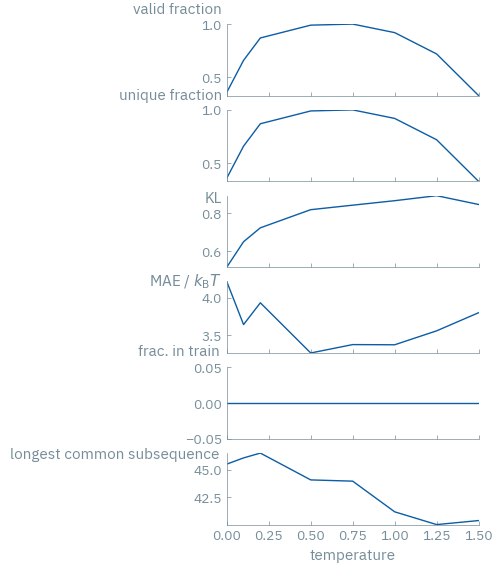

In [31]:

fig, ax = plt.subplots(6,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))

ax[0].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[0].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['valid_fraction']['mean'] -  grouped.loc[100, :]['valid_fraction']['std'], 
    grouped.loc[100, :]['valid_fraction']['mean'] +  grouped.loc[100, :]['valid_fraction']['std'], alpha=.5 )
matplotx.ylabel_top('valid fraction', ax=ax[0])


ax[1].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
ax[1].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['unique_fraction']['mean'] -  grouped.loc[100, :]['unique_fraction']['std'], 
    grouped.loc[100, :]['unique_fraction']['mean'] +  grouped.loc[100, :]['unique_fraction']['std'], alpha=.5 )
matplotx.ylabel_top('unique fraction', ax=ax[1])

ax[2].plot(grouped.loc[100, :].index, grouped.loc[100, :]['kldiv_score']['mean'])
ax[2].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['kldiv_score']['mean'] -  grouped.loc[100, :]['kldiv_score']['std'], 
    grouped.loc[100, :]['kldiv_score']['mean'] +  grouped.loc[100, :]['kldiv_score']['std'], alpha=.5 )
matplotx.ylabel_top('KL', ax=ax[2])

ax[3].plot(grouped.loc[100, :].index, grouped.loc[100, :]['mae']['mean'])
ax[3].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['mae']['mean'] -  grouped.loc[100, :]['mae']['std'], 
    grouped.loc[100, :]['mae']['mean'] +  grouped.loc[100, :]['mae']['std'], alpha=.5 )
matplotx.ylabel_top('MAE / $k_\mathrm{B}T$', ax=ax[3])

ax[4].plot(grouped.loc[100, :].index, grouped.loc[100, :]['fraction_in_train']['mean'])
ax[4].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['fraction_in_train']['mean'] -  grouped.loc[100, :]['fraction_in_train']['std'], 
    grouped.loc[100, :]['fraction_in_train']['mean'] +  grouped.loc[100, :]['fraction_in_train']['std'], alpha=.5 )
ylabel_top('frac. in train', ax=ax[4])


ax[5].plot(grouped.loc[100, :].index, grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'])
ax[5].fill_between(
    grouped.loc[100, :].index,
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] -  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], 
    grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] +  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], alpha=.5 )
ylabel_top('longest common subsequence', ax=ax[5])

ax[-1].set_xlabel('temperature', labelpad=4)
fig.savefig('random_polymer_inverse.pdf', bbox_inches='tight')

In [68]:
np.abs(get_polymer_data()['deltaGmin'].mean() - get_polymer_data()['deltaGmin']).mean()

2.7135963497608304